In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../data/data/porttinari_labeled_final.csv')
data

,dialogue_id,sentence_id,sentences,tipo dimensão multi,Dimensão multi,função multi,revisado,tipo dimensão,Dimensão,função,Unnamed: 10,possivel tag,dialogue_id.1,tokens,pos
0,DOC000001,SENT003,"Eu sei que tô lascado , todo dia tem um proces...",General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,disagreement,NaN,NaN,DOC000001,"['Eu', 'sei', 'que', 'tô', 'lascado', ',', 'to...","['PRON', 'VERB', 'SCONJ', 'AUX', 'ADJ', 'PUNCT..."
1,DOC000001,SENT004,"Eu não quero nem que Moro me absolva , eu só q...",General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC000001,"['Eu', 'não', 'quero', 'nem', 'que', 'Moro', '...","['PRON', 'ADV', 'VERB', 'ADV', 'SCONJ', 'PROPN..."
2,DOC000001,SENT005,Eles [ investigadores ] chegam a dizer : ' Ah ...,General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC000001,"['Eles', '[', 'investigadores', ']', 'chegam',...","['PRON', 'PUNCT', 'NOUN', 'PUNCT', 'VERB', 'AD..."
3,DOC000001,SENT008,"O ex-presidente disse ainda não ter "" medo "" d...",General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC000001,"['O', 'ex-presidente', 'disse', 'ainda', 'não'...","['DET', 'NOUN', 'VERB', 'ADV', 'ADV', 'VERB', ..."
4,DOC000001,SENT010,"De acordo com aliados , Lula não gosta de disc...",General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC000001,"['De', 'acordo', 'com', 'aliados', ',', 'Lula'...","['ADP', 'NOUN', 'ADP', 'NOUN', 'PUNCT', 'PROPN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,DOC004526,SENT006,Desde a ruptura do modelo de industrialização ...,General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC004526,"['Desde', 'a', 'ruptura', 'do', 'de', 'o', 'mo...","['ADP', 'DET', 'NOUN', '_', 'ADP', 'DET', 'NOU..."
4087,DOC004619,SENT008,"Acho que é ... olha , nem consigo achar um adj...",General-purpose function / Dimension-specific ...,Information-providing functions / Social obli...,inform / compliment,duvida,Dimension-specific functions,Social obligations management functions,inform,NaN,compliment,DOC004619,"['Acho', 'que', 'é', '...', 'olha', ',', 'nem'...","['VERB', 'SCONJ', 'AUX', 'PUNCT', 'VERB', 'PUN..."
4088,DOC004679,SENT030,""" Acho que me acostumei com o clima do bairro ...",General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC004679,"['""', 'Acho', 'que', 'me', 'acostumei', 'com',...","['PUNCT', 'VERB', 'SCONJ', 'PRON', 'VERB', 'AD..."
4089,DOC004774,SENT007,"Ele já se movimenta há meses , contatando lide...",General-purpose function,Information-providing functions,inform,sim,General-purpose function,Information-providing functions,inform,NaN,NaN,DOC004774,"['Ele', 'já', 'se', 'movimenta', 'há', 'meses'...","['PRON', 'ADV', 'PRON', 'VERB', 'VERB', 'NOUN'..."


In [3]:
data['função'].value_counts()

função
inform                 3905
question                 95
instruct                 15
suggest                  14
disagreement             12
answer                   12
confirm                   7
agreement                 7
correction                5
compliment                4
sympathy expression       3
request                   3
thanking                  3
disconfirm                3
congratulations           1
promise                   1
apology                   1
Name: count, dtype: int64

In [4]:
dimension={"information-providing functions":["inform", 
                                    "agreement", 
                                    "disagreement", 
                                    "confirm", 
                                    "disconfirm", "correction",
                                    "answer"],
"information-seeking functions": ["question"],
"directive functions": ["instruct", "suggest", "request"],
"commissive functions": ["promise"],
"social obligations management functions": ["compliment", "sympathy expression", "thanking", "congratulations", "apology"]
}

In [5]:
def map_function(func_value):
    for key, values in dimension.items():
        if func_value in values:
            return key
    return None  # Ou qualquer outro valor padrão para quando não houver correspondência

# Aplicar a função de mapeamento à coluna "função"
data['new_dimension'] = data['função'].map(map_function)

In [6]:
data['new_dimension'].value_counts()

new_dimension
information-providing functions            3951
information-seeking functions                95
directive functions                          32
social obligations management functions      12
commissive functions                          1
Name: count, dtype: int64

In [7]:
all_results = pd.read_csv(r'../data/outputs/results/results.csv').set_index('Unnamed: 0')
all_results.columns

Index(['precision', 'recall', 'f1-score', 'support', 'model_name', 'dataset',
       'use_pos', 'use_context', 'use_trans', 'use_weights', 'batch_size',
       'epoch', 'lr_rate', 'resample_perc', 'n_classes', 'timestamp_now'],
      dtype='object')

In [8]:
import itertools
list_resample_perc = [0.1, 0.05, 0.01]
list_lr_rate = [5e-5, 1e-5, 5e-6]
list_pos = [True, False]
list_context = [True, False]
list_trans = [True, False]
list_use_weights = [True, False]

all_combinations = itertools.product(*[list_pos, list_context, list_trans, list_resample_perc, list_lr_rate, list_use_weights])


best_comb_results = []
for pos, con, trans, resample, lr_rate, use_weights in all_combinations:
    best_epoch = all_results[(all_results['model_name']=='main') & (all_results['use_pos']==pos) & (all_results['use_trans']==trans) 
            & (all_results['use_context']==con)  & (all_results['dataset']=='test') & (all_results['lr_rate']==	lr_rate) &
            (all_results['resample_perc']==resample) & (all_results['use_weights']==use_weights) & (all_results['dataset']=='test')].iloc[-1]['epoch']
    best_comb_results.append([pos, con, trans, resample, lr_rate, use_weights, best_epoch])

all_combinations = itertools.product(*[list_pos, list_context, list_trans])

df_best_comb_results = pd.DataFrame(best_comb_results, columns=["pos", "con", "trans", "resample", "lr_rate", "use_weights", "best_epoch"])
all_best = pd.DataFrame()
for pos, con, trans in all_combinations:
    df_all_best_comb = df_best_comb_results[(df_best_comb_results['pos']==pos) & (df_best_comb_results['con']==con) & (df_best_comb_results['trans']==trans)]

    best_results_comb = pd.DataFrame()
    for idx, row in df_all_best_comb.iterrows():
        best_results_comb = pd.concat([best_results_comb, all_results[(all_results['model_name']=='main') & (all_results['use_pos']==row["pos"]) & (all_results['use_trans']==row["trans"]) 
                & (all_results['use_context']==row["con"])  & (all_results['lr_rate']==row["lr_rate"]) &
                (all_results['resample_perc']==row['resample']) & (all_results['use_weights']==row["use_weights"]) & (all_results['dataset']=='val')
                & (all_results['epoch']==row['best_epoch'])]])
    best_params = best_results_comb.loc['macro avg'].sort_values(['f1-score'], ascending=False).iloc[0]
    all_best = pd.concat([
        all_best,  best_results_comb[(best_results_comb['model_name']=='main') & (best_results_comb['use_pos']==best_params["use_pos"]) & (best_results_comb['use_trans']==best_params["use_trans"]) 
                & (best_results_comb['use_context']==best_params["use_context"])  & (best_results_comb['lr_rate']==best_params["lr_rate"]) &
                (best_results_comb['resample_perc']==best_params['resample_perc']) & (best_results_comb['use_weights']==best_params["use_weights"]) & (best_results_comb['dataset']=='val')
                & (best_results_comb['epoch']==best_params['epoch'])]
    ])    

In [9]:
all_best.loc['macro avg'].sort_values(['f1-score'], ascending=False)

,precision,recall,f1-score,support,model_name,dataset,use_pos,use_context,use_trans,use_weights,batch_size,epoch,lr_rate,resample_perc,n_classes,timestamp_now
Unnamed: 0,,,,,,,,,,,,,,,,
macro avg,0.583403,0.694340,0.609012,434.0,main,val,True,False,True,True,4,13,0.000005,0.10,7,2024-06-22 21:44:45
macro avg,0.506730,0.654088,0.533477,434.0,main,val,False,False,False,False,4,13,0.000010,0.05,7,2024-06-24 20:23:58
macro avg,0.498077,0.594340,0.529524,434.0,main,val,False,True,False,True,4,11,0.000010,0.10,7,2024-06-24 02:38:58
macro avg,0.464691,0.589151,0.508638,434.0,main,val,False,False,True,False,4,19,0.000005,0.05,7,2024-06-24 15:02:06
macro avg,0.459808,0.776415,0.487654,434.0,main,val,True,False,False,False,4,5,0.000050,0.05,7,2024-06-23 12:24:40
macro avg,0.435916,0.497248,0.459369,434.0,main,val,True,True,True,True,4,12,0.000050,0.10,7,2024-06-21 13:51:25
macro avg,0.306933,0.551038,0.345127,434.0,main,val,False,True,True,True,4,6,0.000050,0.05,7,2024-06-23 20:15:22
macro avg,0.295830,0.483491,0.327807,434.0,main,val,True,True,False,False,4,12,0.000005,0.10,7,2024-06-22 10:51:56


In [10]:
#all_best.loc['macro avg'].sort_values(['f1-score'], ascending=False).to_csv("../data/outputs/results/best_params.csv", index=False)

In [11]:
best_test = pd.DataFrame()
for idx, row in all_best.loc['macro avg'].sort_values(['f1-score'], ascending=False).iterrows():
    epoch = all_results[(all_results['model_name']=='main') & (all_results['use_pos']==row["use_pos"]) & (all_results['use_trans']==row["use_trans"]) 
                & (all_results['use_context']==row["use_context"])  & (all_results['lr_rate']==row["lr_rate"]) &
                (all_results['resample_perc']==row['resample_perc']) & (all_results['use_weights']==row["use_weights"]) & (all_results['dataset']=='test')].iloc[-1]['epoch']
    
    test_results = all_results[(all_results['model_name']=='main') & (all_results['use_pos']==row["use_pos"]) & (all_results['use_trans']==row["use_trans"]) 
                & (all_results['use_context']==row["use_context"])  & (all_results['lr_rate']==row["lr_rate"]) &
                (all_results['resample_perc']==row['resample_perc']) & (all_results['use_weights']==row["use_weights"]) & (all_results['dataset']=='test')
                & (all_results['epoch']==epoch)][:10]

    if 'suggest' not in test_results.index:
        print('oi')
        cols_zeros = list(range(len(test_results.columns)))
        test_results.loc['suggest'] = cols_zeros 
    
    best_test = pd.concat([best_test, test_results])
best_test  

,precision,recall,f1-score,support,model_name,dataset,use_pos,use_context,use_trans,use_weights,batch_size,epoch,lr_rate,resample_perc,n_classes,timestamp_now
Unnamed: 0,,,,,,,,,,,,,,,,
answer,0.000000,0.000000,0.000000,1.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
disagreement,0.000000,0.000000,0.000000,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
inform,0.992070,0.976583,0.984266,1153.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
instruct,0.333333,0.333333,0.333333,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
other,0.105263,0.333333,0.160000,6.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
question,0.400000,1.000000,0.571429,20.000000,main,test,True,True,False,False,4,12,0.000005,0.1,7,2024-06-22 10:53:05
suggest,0.000000,0.000000,0.000000,3.000000,main,test,True,True,False,False,4,12,0.000005,0.1,7,2024-06-22 10:53:05
accuracy,0.904962,0.904962,0.904962,0.904962,main,test,True,True,False,False,4,12,0.000005,0.1,7,2024-06-22 10:53:05


In [12]:
best_test[(best_test['use_pos']==True) & (best_test['use_context']==False) & (best_test['use_trans']==True)]

,precision,recall,f1-score,support,model_name,dataset,use_pos,use_context,use_trans,use_weights,batch_size,epoch,lr_rate,resample_perc,n_classes,timestamp_now
Unnamed: 0,,,,,,,,,,,,,,,,
answer,0.000000,0.000000,0.000000,1.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
disagreement,0.000000,0.000000,0.000000,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
inform,0.992070,0.976583,0.984266,1153.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
instruct,0.333333,0.333333,0.333333,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
other,0.105263,0.333333,0.160000,6.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
question,0.833333,1.000000,0.909091,20.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
suggest,0.333333,0.333333,0.333333,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
accuracy,0.967199,0.967199,0.967199,0.967199,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
macro avg,0.371048,0.425226,0.388575,1189.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35


In [13]:
best_test[(best_test['use_pos']==False) & (best_test['use_context']==False) & (best_test['use_trans']==False)]

,precision,recall,f1-score,support,model_name,dataset,use_pos,use_context,use_trans,use_weights,batch_size,epoch,lr_rate,resample_perc,n_classes,timestamp_now
Unnamed: 0,,,,,,,,,,,,,,,,
answer,0.100000,1.000000,0.181818,1.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
disagreement,0.000000,0.000000,0.000000,3.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
inform,0.989964,0.941023,0.964873,1153.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
instruct,0.200000,0.333333,0.250000,3.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
other,0.071429,0.333333,0.117647,6.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
question,0.833333,1.000000,0.909091,20.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
suggest,0.000000,0.000000,0.000000,3.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
accuracy,0.932717,0.932717,0.932717,0.932717,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28
macro avg,0.313532,0.515384,0.346204,1189.000000,main,test,False,False,False,False,4,13,0.00001,0.05,7,2024-06-24 20:24:28


In [14]:
#best_test = best_test.drop(columns=['timestamp_now'])
#best_test = best_test.drop_duplicates()

In [15]:
best_test[(best_test['use_pos']==True) & (best_test['use_context']==False) & (best_test['use_trans']==True)]

,precision,recall,f1-score,support,model_name,dataset,use_pos,use_context,use_trans,use_weights,batch_size,epoch,lr_rate,resample_perc,n_classes,timestamp_now
Unnamed: 0,,,,,,,,,,,,,,,,
answer,0.000000,0.000000,0.000000,1.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
disagreement,0.000000,0.000000,0.000000,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
inform,0.992070,0.976583,0.984266,1153.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
instruct,0.333333,0.333333,0.333333,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
other,0.105263,0.333333,0.160000,6.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
question,0.833333,1.000000,0.909091,20.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
suggest,0.333333,0.333333,0.333333,3.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
accuracy,0.967199,0.967199,0.967199,0.967199,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35
macro avg,0.371048,0.425226,0.388575,1189.000000,main,test,True,False,True,True,4,13,0.000005,0.1,7,2024-06-22 21:45:35


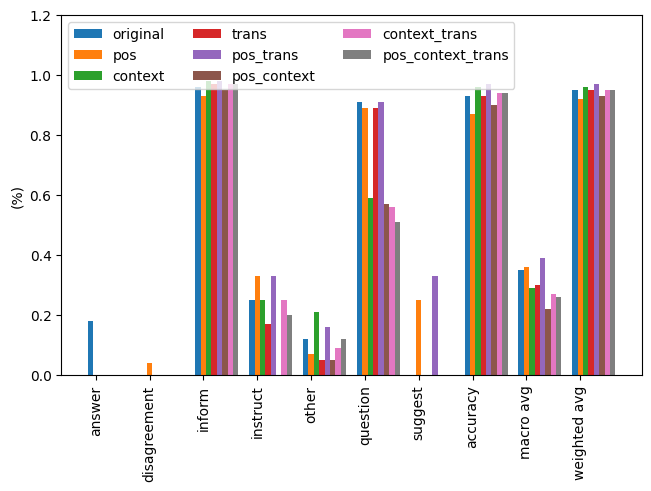

In [16]:
import matplotlib.pyplot as plt
import numpy as np

classes = (list(best_test[(best_test['use_pos']==False) & (best_test['use_context']==False) & (best_test['use_trans']==False)].index))
perc = {
    'original': list(best_test[(best_test['use_pos']==False) & (best_test['use_context']==False) & (best_test['use_trans']==False)]['f1-score'].round(2)),
    'pos': list(best_test[(best_test['use_pos']==True) & (best_test['use_context']==False) & (best_test['use_trans']==False)]['f1-score'].round(2)),
    'context': list(best_test[(best_test['use_pos']==False) & (best_test['use_context']==True) & (best_test['use_trans']==False)]['f1-score'].round(2)),
    'trans': list(best_test[(best_test['use_pos']==False) & (best_test['use_context']==False) & (best_test['use_trans']==True)]['f1-score'].round(2)),
    'pos_trans': list(best_test[(best_test['use_pos']==True) & (best_test['use_context']==False) & (best_test['use_trans']==True)]['f1-score'].round(2)),
    'pos_context': list(best_test[(best_test['use_pos']==True) & (best_test['use_context']==True) & (best_test['use_trans']==False)]['f1-score'].round(2)),
    'context_trans': list(best_test[(best_test['use_pos']==False) & (best_test['use_context']==True) & (best_test['use_trans']==True)]['f1-score'].round(2)),
    'pos_context_trans': list(best_test[(best_test['use_pos']==True) & (best_test['use_context']==True) & (best_test['use_trans']==True)]['f1-score'].round(2)),
}

x = np.arange(len(classes))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in perc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('(%)')
#ax.set_title('Speech act classes f1')
ax.set_xticks(x + width, classes, rotation=90)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

In [17]:
pd.DataFrame(perc)

,original,pos,context,trans,pos_trans,pos_context,context_trans,pos_context_trans
0,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00
2,0.96,0.93,0.98,0.97,0.98,0.95,0.97,0.97
3,0.25,0.33,0.25,0.17,0.33,0.00,0.25,0.20
4,0.12,0.07,0.21,0.05,0.16,0.05,0.09,0.12
5,0.91,0.89,0.59,0.89,0.91,0.57,0.56,0.51
6,0.00,0.25,0.00,0.00,0.33,0.00,0.00,0.00
7,0.93,0.87,0.96,0.93,0.97,0.90,0.94,0.94
8,0.35,0.36,0.29,0.30,0.39,0.22,0.27,0.26
9,0.95,0.92,0.96,0.95,0.97,0.93,0.95,0.95
